### Import library

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import tensorflow
import torchvision.transforms as transforms

import glob
from PIL import Image
from tensorflow.keras.preprocessing import image
import tensorflow.keras
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt

# Autoencoder
from keras.layers import Input, Dense
from keras.models import Model
import keras

### Define the path of the dataset

In [2]:
train_path = '/kaggle/input/cats-and-dogs-image-classification/train'
test_path = '/kaggle/input/cats-and-dogs-image-classification/test'

### Pre-process the images
#### Resize the images to 224 x 224 px with pad
#### Images with same size is critical when using Autoencoders as the algorithm

In [3]:
def resize_with_padding(image, target_size = 224):
    # Open the image and convert to RGB
    img = Image.open(image).convert('RGB')
    
    # Get original dimensions
    orig_width, orig_height = img.size
    ratio = min(target_size / orig_width, target_size / orig_height)
    
    # Resize while preserving aspect ratio
    new_width = int(orig_width * ratio)
    new_height = int(orig_height * ratio)
    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Create a new blank image with the target size and black padding
    padded_img = Image.new('RGB', (target_size, target_size), (0, 0, 0))  # Black padding
    
    # Calculate padding offsets to center the image
    pad_left = (target_size - new_width) // 2
    pad_top = (target_size - new_height) // 2
    
    # Paste the resized image onto the padded canvas
    padded_img.paste(img, (pad_left, pad_top))
    
    # Convert to tensor and normalize to [0, 1]
    # to_tensor = transforms.ToTensor()
    # img_tensor = to_tensor(padded_img)
    img_tensor = padded_img
    
    return img_tensor

In [4]:
# Load images to the array
# Cat images
images = []
for f in glob.iglob(train_path + "/cats/*.jpg"):
    f = resize_with_padding(f)
    images.append(np.asarray(f))

cat_images = np.array(images)

# Dog images
images = []
for f in glob.iglob(train_path + "/dogs/*.jpg"):
    f = resize_with_padding(f)
    images.append(np.asarray(f))

dog_images = np.array(images)

In [5]:
images = np.concatenate((cat_images, dog_images))

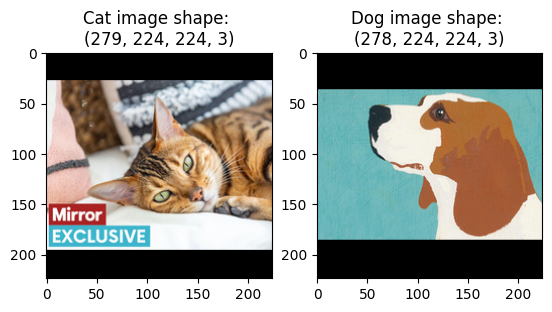

In [6]:
plt.subplot(1, 2, 1)
plt.imshow(cat_images[11]);
plt.title(f"Cat image shape: \n{cat_images.shape}")

plt.subplot(1, 2, 2)
plt.imshow(dog_images[11]);
plt.title(f"Dog image shape: \n{dog_images.shape}")

plt.show()

---  
### Building the encoder and decoder

---  
### Grok

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

IMG_HEIGHT = 224
IMG_WIDTH = 224
LATENT_DIM = 512  # Size of the latent space

In [43]:
# 2. Build the Autoencoder
def build_autoencoder(img_shape, LATENT_DIM = 512):
    # Encoder
    encoder = keras.models.Sequential()
    encoder.add(layers.Input(img_shape))
    encoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))  # 112x112
    encoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))  # 56x56
    encoder.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))  # 28x28
    encoder.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))  # 14x14
    encoder.add(layers.Flatten())  # 14 * 14 * 256 = 50,176
    encoder.add(layers.Dense(LATENT_DIM))  # 256
    


    
    # Decoder
    decoder = keras.models.Sequential()
    decoder.add(layers.Input(shape=(LATENT_DIM,)))
    decoder.add(layers.Dense(14 * 14 * 256))  # Reverse the flatten
    decoder.add(layers.Reshape((14, 14, 256)))  # 14x14
    decoder.add(layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.UpSampling2D((2, 2)))  # 28x28
    decoder.add(layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.UpSampling2D((2, 2)))  # 56x56
    decoder.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.UpSampling2D((2, 2)))  # 112x112
    decoder.add(layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.UpSampling2D((2, 2)))  # 224x224
    decoder.add(layers.Conv2D(3, (3, 3), activation=None, padding='same'))
    
    

    return encoder, decoder

In [44]:
IMG_SHAPE = images.shape[1:]
IMG_SHAPE

(224, 224, 3)

In [45]:
# Create and compile the model
encoder, decoder = build_autoencoder(IMG_SHAPE, LATENT_DIM)
encoder.summary()
decoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      25,690,624 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,079,040 (99.48 MB)

 Trainable params: 26,079,040 (99.48 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 50176)               │      25,740,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 56, 56, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 112, 112, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,718,531 (101.92 MB)

 Trainable params: 26,718,531 (101.92 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# # Autoencoder
img_shape = images.shape[1:]
autoencoder_input = layers.Input(img_shape)
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = models.Model(inputs = autoencoder_input, outputs = decoded, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')

In [47]:
# 3. Train the Autoencoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, fill_mode='nearest')
datagen.fit(images)




autoencoder.fit(x=images, y=images,  # Input and target are the same
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                verbose=1)

# lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
# autoencoder.fit(x=images, y=images, epochs=100, batch_size=32, validation_split=0.2, callbacks=[lr_schedule])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - loss: 20373.8789 - val_loss: 5672.7930
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5618.0850 - val_loss: 5024.3345
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4545.7183 - val_loss: 4051.2993
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4239.7998 - val_loss: 4021.1880
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3724.5791 - val_loss: 3467.7849
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3555.7236 - val_loss: 3427.5024
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3305.5862 - val_loss: 3250.5669
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2994.9141 - val_loss: 3301.6433
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3022.3423 - val_loss: 2996.5061
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2838.7422 - val_loss: 2909.9082
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2681.2036 - val_

In [48]:
# 4. Extract latent features
imagess = images
encoded_images  = encoder.predict(imagess)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [14]:
# import warnings
# warnings.filterwarnings('ignore')
# # 5. Cluster the latent features (cats vs dogs)
# kmeans = KMeans(n_clusters=2, random_state=42)
# cluster_labels = kmeans.fit_predict(encoded_images)

In [15]:
# # 6. Visualize some results
# def plot_examples(images, labels, num_examples=5):
#     plt.figure(figsize=(15, 3))
#     for i in range(num_examples):
#         # Original image
#         plt.subplot(2, num_examples, i + 1)
#         plt.imshow(images[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
#         plt.title(f'Cluster {labels[i]}')
#         plt.axis('off')
        
#         # Reconstructed image
#         reconstructed = autoencoder.predict(images[i:i+1])
#         plt.subplot(2, num_examples, i + num_examples + 1)
#         plt.imshow(reconstructed[0].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
#         plt.axis('off')
#     plt.show()

In [16]:
# # Show some examples
# plot_examples(images, cluster_labels)

In [17]:
# # 7. Print cluster distribution
# print("Cluster distribution (0 and 1 represent cats/dogs):")
# print(np.bincount(cluster_labels))


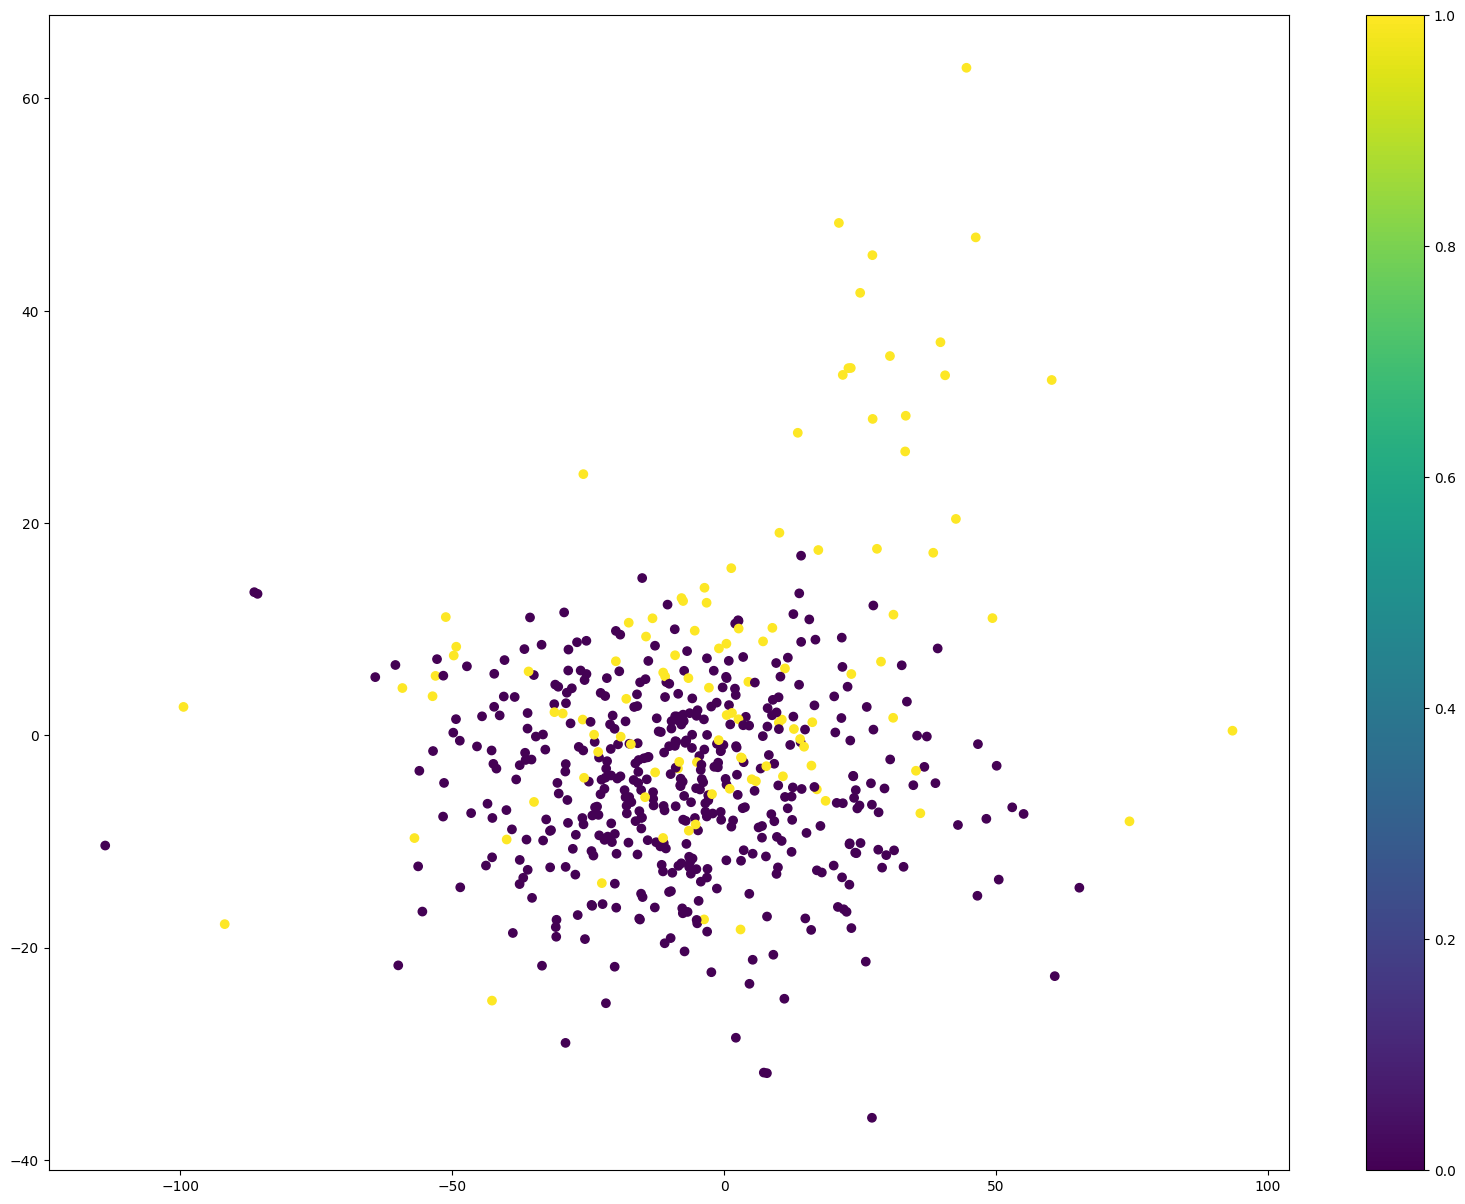

In [49]:
#Clustering using Kmeans:
#Assuming we have 6 classes:e.g. lion, tiger, cheetah, leopard, wolf, fox

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init=20, random_state=42)
kmeans.fit(encoded_images)
plt.figure(figsize=(20, 15))
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=kmeans.labels_)
plt.colorbar()
plt.show()

In [50]:
###Fitting our encoded images on Nearest Neighbors algorithms to retrieve similar images

from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(encoded_images)

NearestNeighbors(metric='euclidean')

In [51]:


#Function for retrieving distances and indexes of similar images

def get_similar(image, n_neighbors):
    encoded_image = encoder.predict(image[None])
    #Getting distances and indexes of nearest neighbors
    (distances,),(idx,) = nei_clf.kneighbors(encoded_image,n_neighbors=n_neighbors)
    
    return distances,images[idx]
     


#Function for showing similar images:
def show_similar(image,n_neighbors):
    
    distances,neighbors = get_similar(image,n_neighbors)
    n_neighbor = n_neighbors-1 # for For loop
    dim = round(n_neighbors/2)
    #Plot for original image
    plt.figure(figsize=[30,30])
    plt.subplot(dim,dim,1)
    plt.imshow(image)
    plt.title("Original image")
    #Plot for neighbors
    for i in range(n_neighbor):
        plt.subplot(dim,dim,i+2)
        plt.imshow(neighbors[i+1])
        plt.title("Dist=%.3f"%distances[i+1])
    plt.show()
     


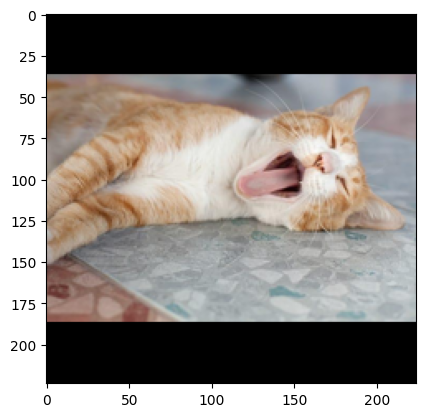

In [52]:
plt.imshow(imagess[40]);

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


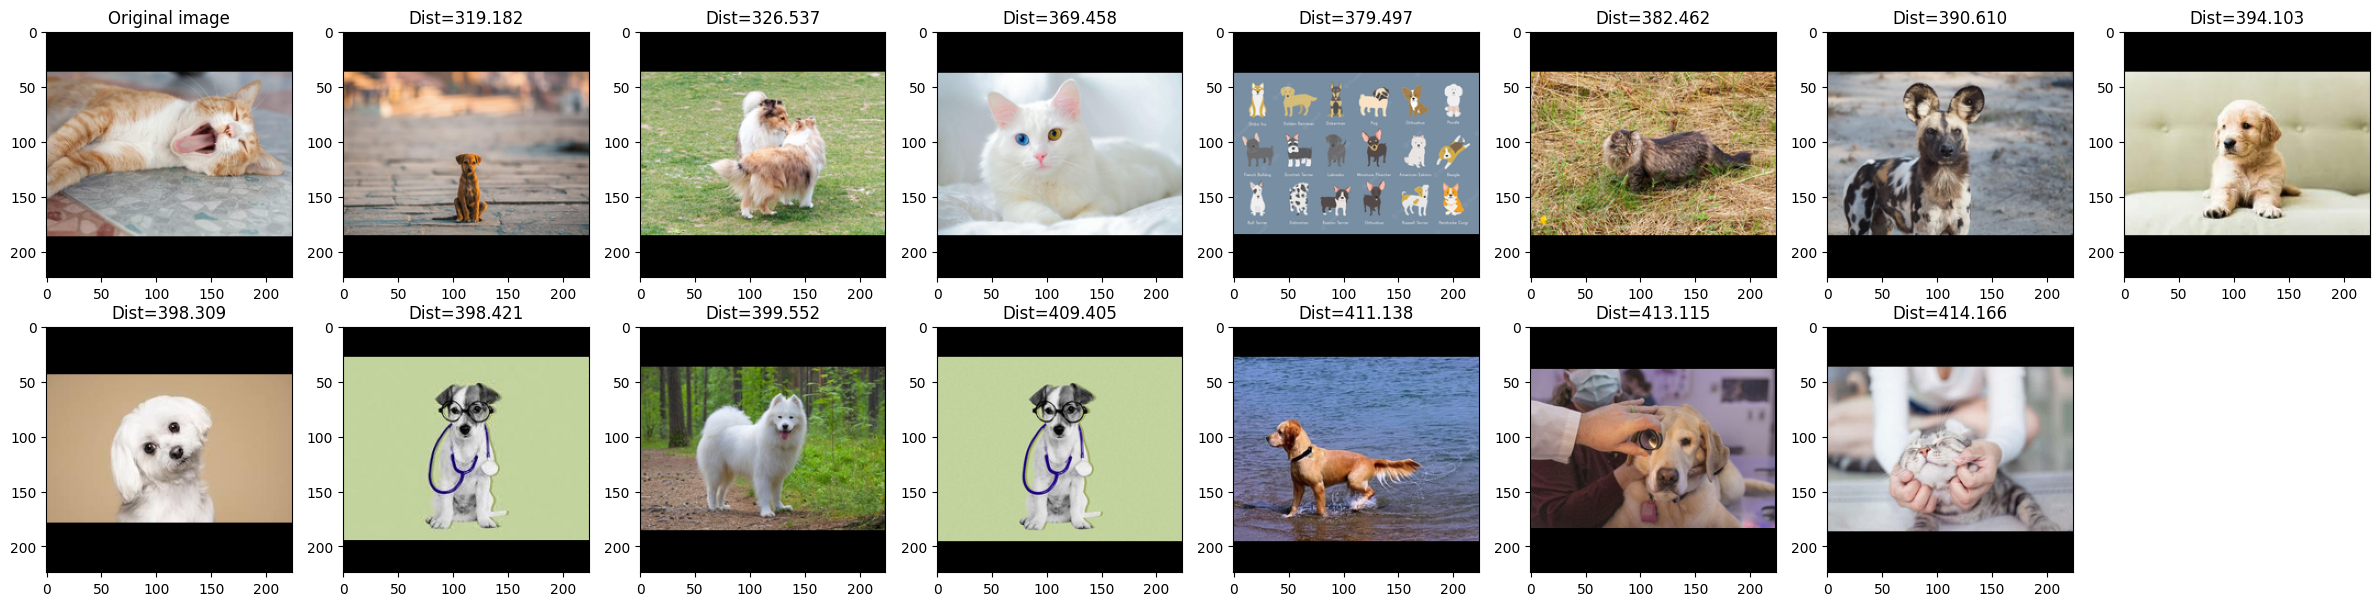

In [53]:
show_similar(imagess[40],15)

In [23]:
# autoencoder.save('/kaggle/working/autoencoder.h5')

In [24]:
# from tensorflow import keras
# autoencoder = keras.models.load_model('/kaggle/working/autoencoder.h5')

### Testing

In [80]:
def load_test_data(base_path):
    images = []
    labels = []
    
    # Define subfolder paths
    cats_path = os.path.join(base_path, 'cats')
    dogs_path = os.path.join(base_path, 'dogs')
    
    # Load cat images (label = 0)
    for filename in os.listdir(cats_path):
        if filename.endswith(('.jpg')):
            img_path = os.path.join(cats_path, filename)
            try:
                img = resize_with_padding(img_path)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(0)  # Label for cats
            except Exception as e:
                print(f"Error processing {filename} in cats: {e}")
                continue
    
    # Load dog images (label = 1)
    for filename in os.listdir(dogs_path):
        if filename.endswith(('.jpg')):
            img_path = os.path.join(dogs_path, filename)
            try:
                img = img = resize_with_padding(img_path)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(1)  # Label for dogs
            except Exception as e:
                print(f"Error processing {filename} in dogs: {e}")
                continue
    
    # Convert to NumPy arrays
    images = np.stack(images)  # Shape: (N, 224, 224)
    labels = np.array(labels, dtype=np.int32)  # Shape: (N,)
    
    return images, labels


In [81]:
test_images, true_labels = load_test_data(test_path)

In [27]:
# # dog = 1 , cat = 0

# categories = os.listdir(test_path)
# test_data_list = []

# for category in categories:
#     category_path = os.path.join(test_path,category)

#     test_datas = os.listdir(category_path)
#     for test_data in test_datas:
#         test_data_path = os.path.join(category_path,test_data)

#         test_data_list.append({'data_path':test_data_path,'label':1 if category == "dogs" else 0})

# test_df = pd.DataFrame(data=test_data_list)

In [82]:
# Get latent features for test data
test_latent_features = encoder.predict(test_images)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [39]:
# Cluster the test data

# import warnings
# warnings.filterwarnings('ignore')

# kmeans = KMeans(n_clusters=2, n_init=20, random_state=42)
# test_cluster_labels = kmeans.fit_predict(test_latent_features)

In [83]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, random_state=42)
test_cluster_labels = gmm.fit_predict(test_latent_features)

In [84]:
# Map clusters to labels (manual step after inspection)
# Example: if cluster 0 is mostly cats (true_labels = 0), keep as is; otherwise, swap
mapped_labels = test_cluster_labels  # Adjust based on inspection (e.g., 1 - test_cluster_labels to swap)


In [85]:
# Calculate accuracy
accuracy = np.mean(mapped_labels == true_labels)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 57.14%


In [86]:

# Visualize some examples
def plot_examples(images, true_labels, pred_labels, num_examples=120):
    plt.figure(figsize=(120, 120))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {true_labels[i]}\nPred: {pred_labels[i]}')
        plt.axis('off')
    plt.show()


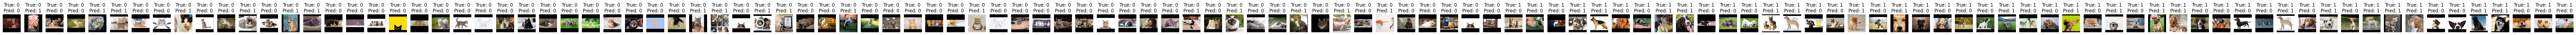

In [87]:

# Show first 5 examples
plot_examples(test_images, true_labels, mapped_labels)